In [ ]:
# !pip install yellowbrick
# library
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#pre-processing
from scipy import stats # to remove outliers
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# data engineering 
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# metrics
from sklearn.metrics import classification_report, confusion_matrix, adjusted_mutual_info_score

In [ ]:
# Connnect to google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load dataset
columns = open("/content/gdrive/MyDrive/AML/Fault_Column_Names.txt", "r",).read().split('\n')[:-1]
df = pd.read_csv('/content/gdrive/MyDrive/AML/Fault_Variables_dataset.csv', sep = '\t', header = None, names = columns)
df_raw = df.copy()
df.rename(columns={"K_Scatch": "K_Scratch"})

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


## Exploratory analysis

In [ ]:
df.describe()
df.isna().sum() # no na

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

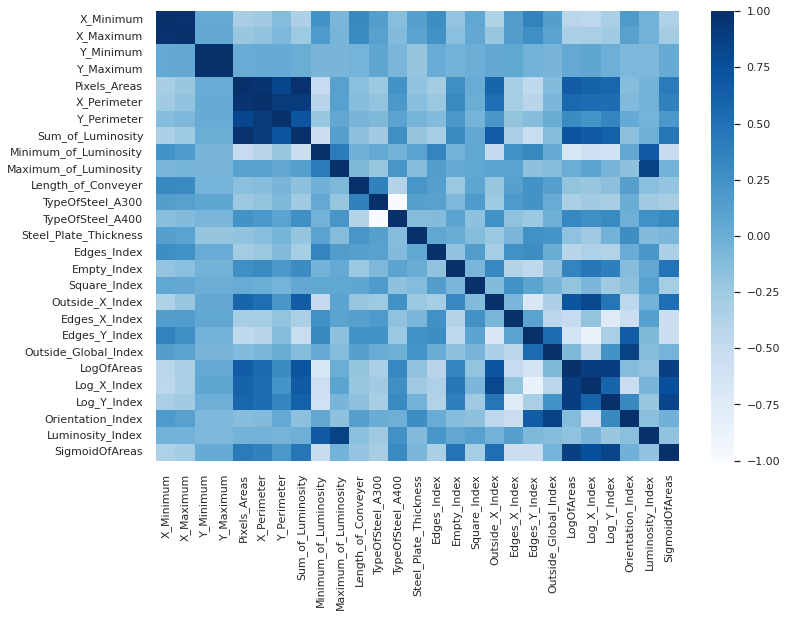

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# plot the heatmap
sns.heatmap(df_raw.iloc[:,:-7].corr(), 
        xticklabels=df.iloc[:,:-7].corr().columns,
        yticklabels=df.iloc[:,:-7].corr().columns, cmap = "Blues") # many features have too high correlation => need to check multicollinearity

In [ ]:
# multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

df = df.drop(['X_Maximum', 'TypeOfSteel_A400', 'Y_Maximum'], axis=1)


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
faults = df.iloc[:,-7:]
feutures = df.iloc[:,:-7]
(faults.sum() / faults.sum().sum()).mul(100) # main faults are Other_Faults, Bumps, and K_Scatch. together they are 76%
faults.sum(axis = 1).max() # it is always one type of fault

1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

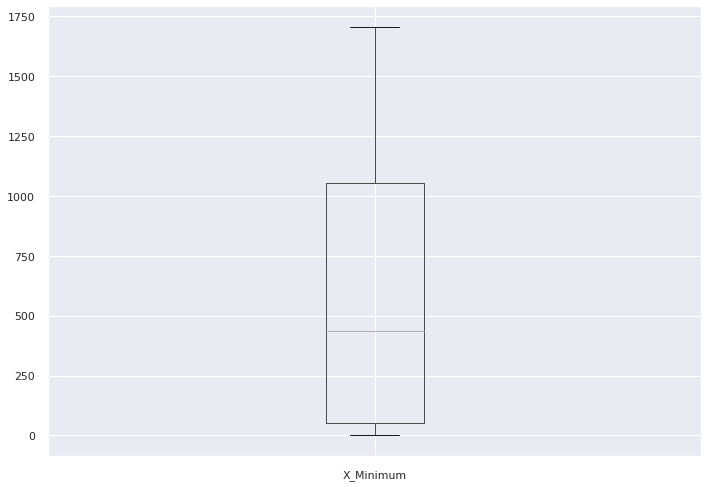

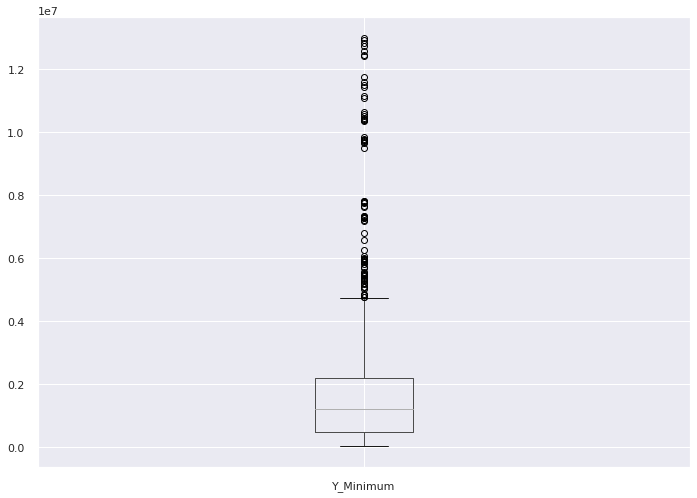

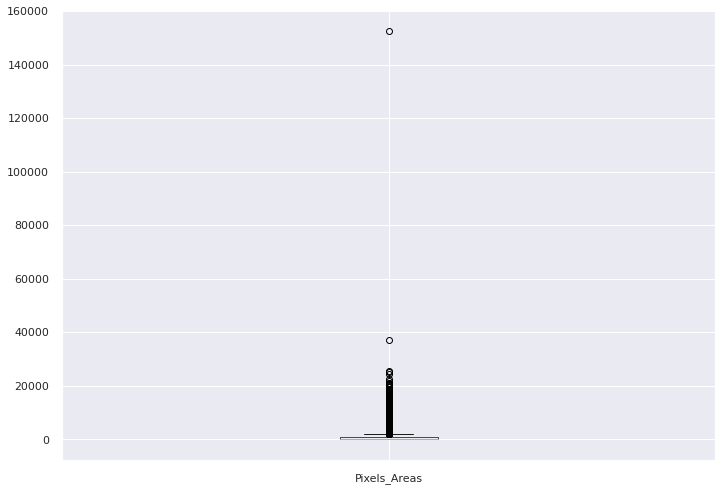

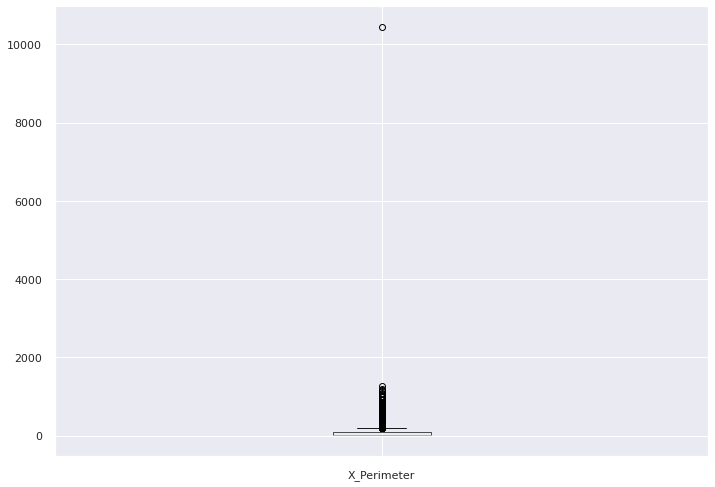

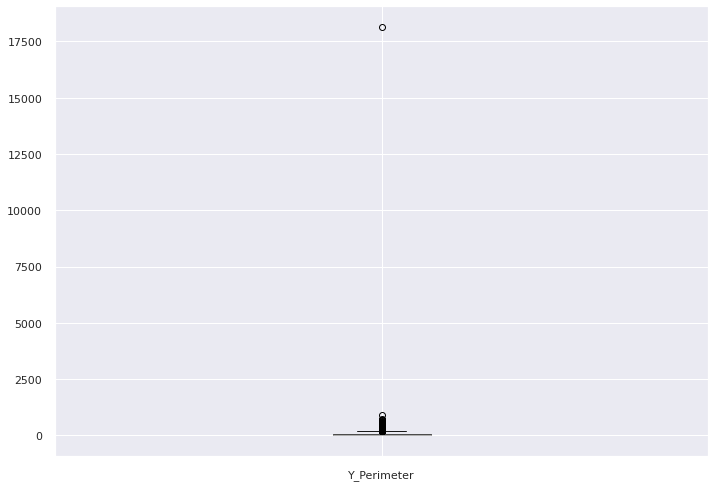

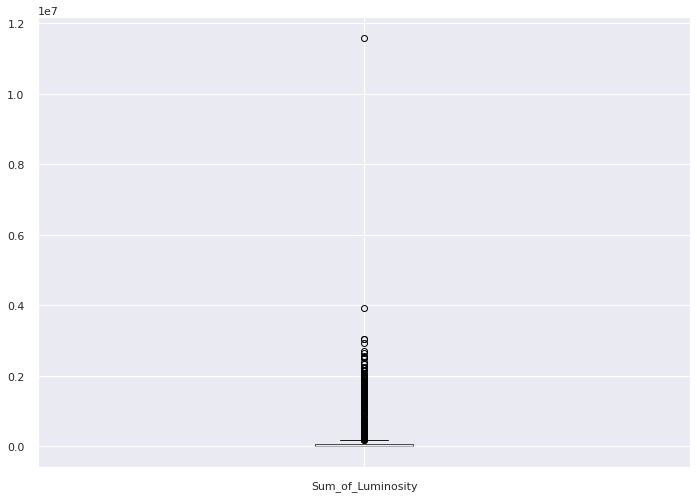

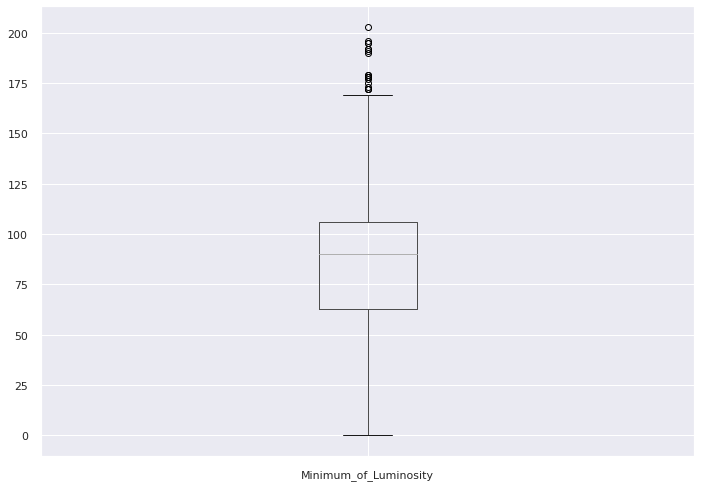

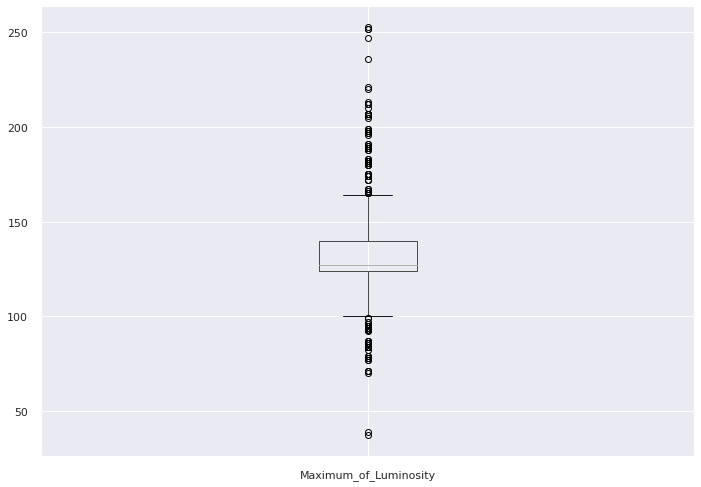

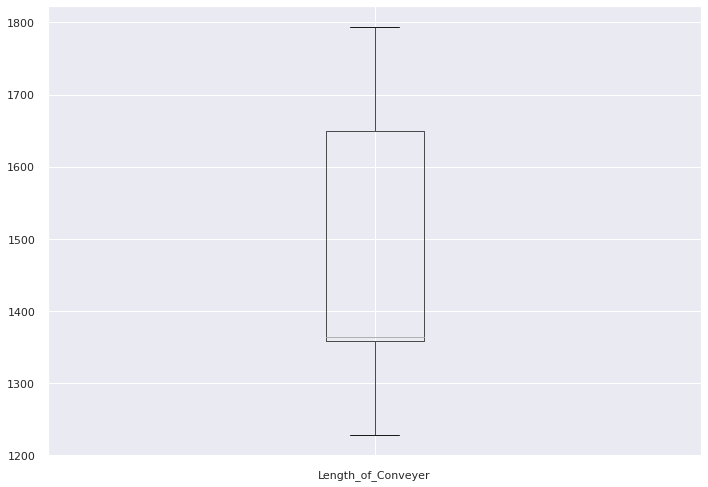

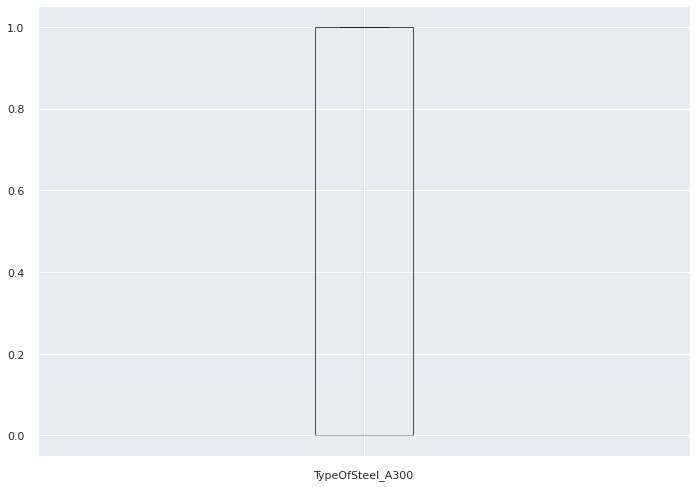

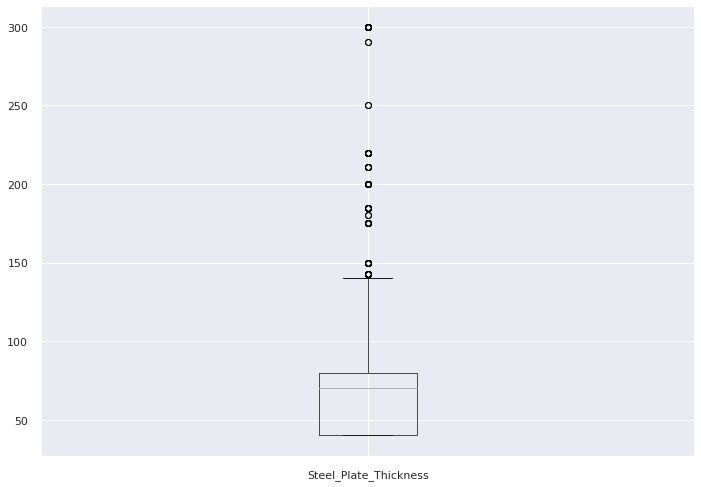

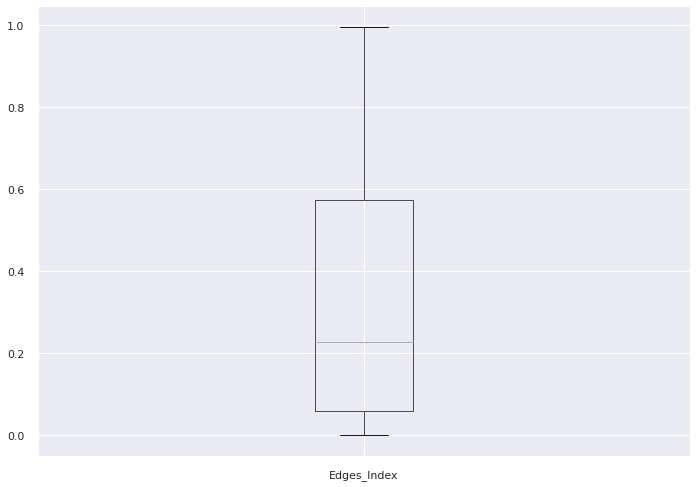

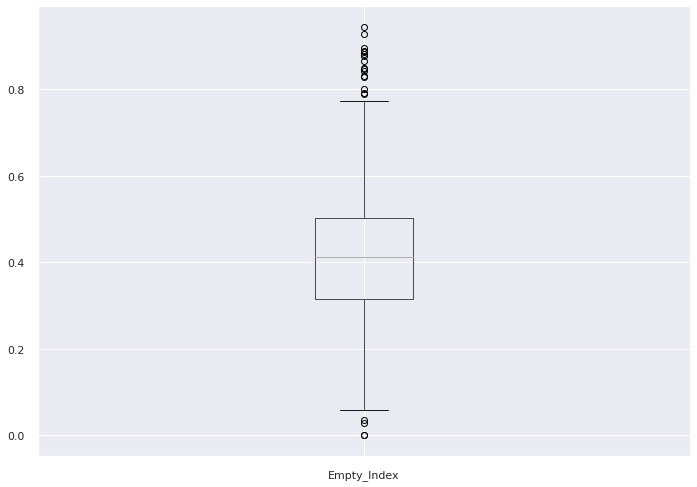

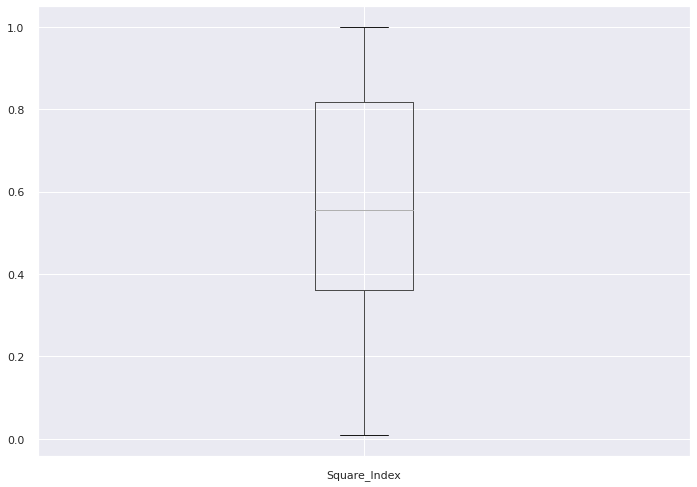

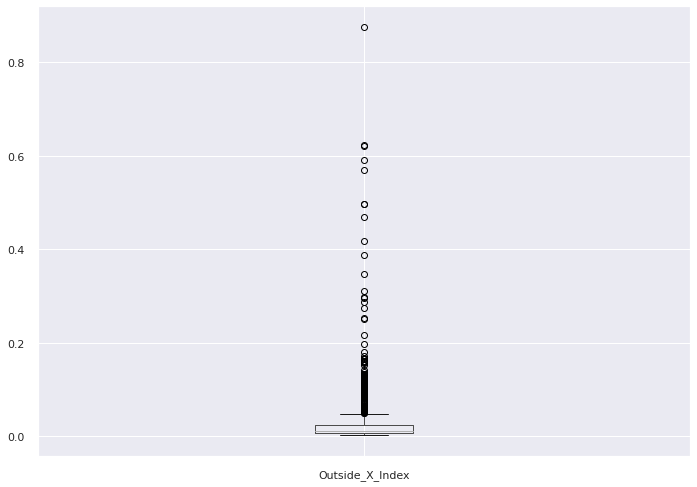

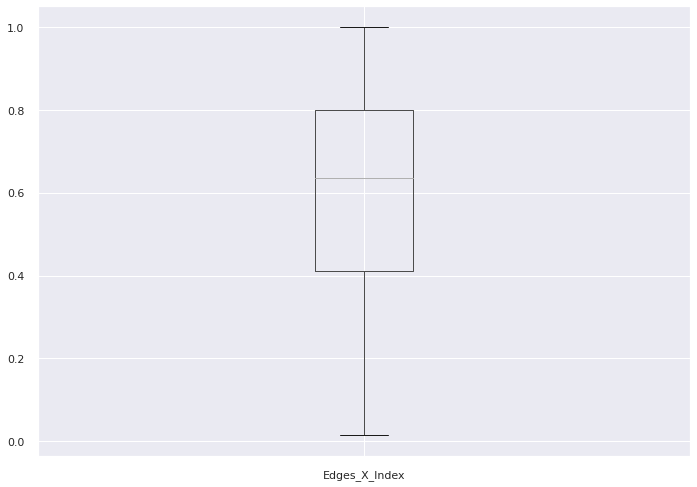

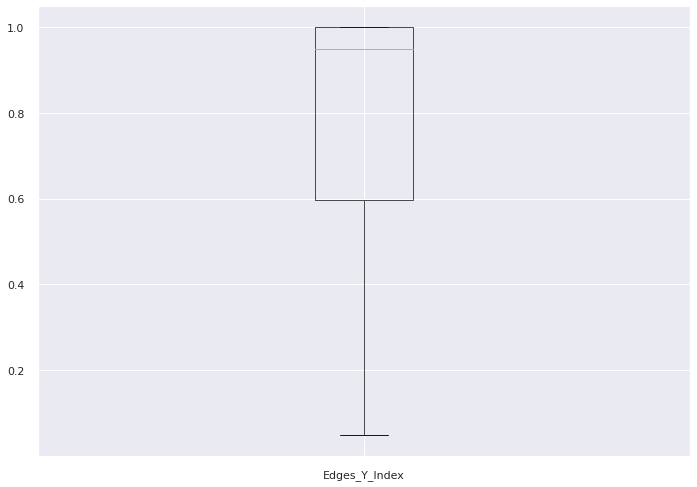

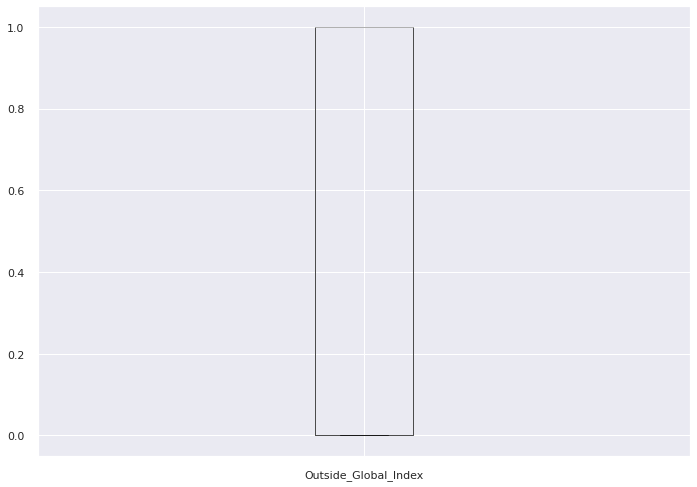

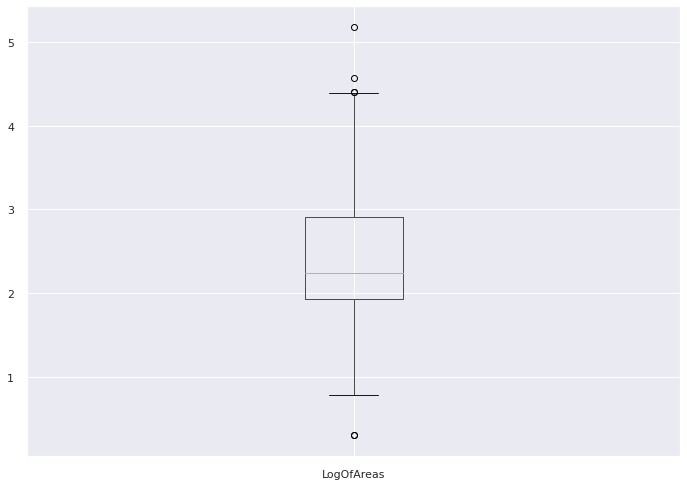

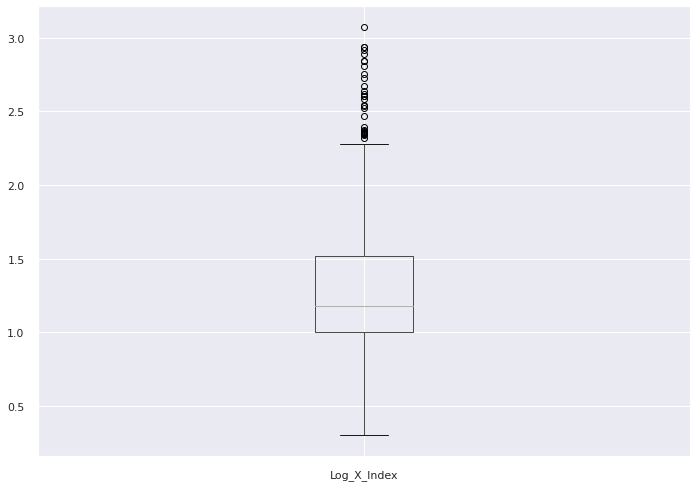

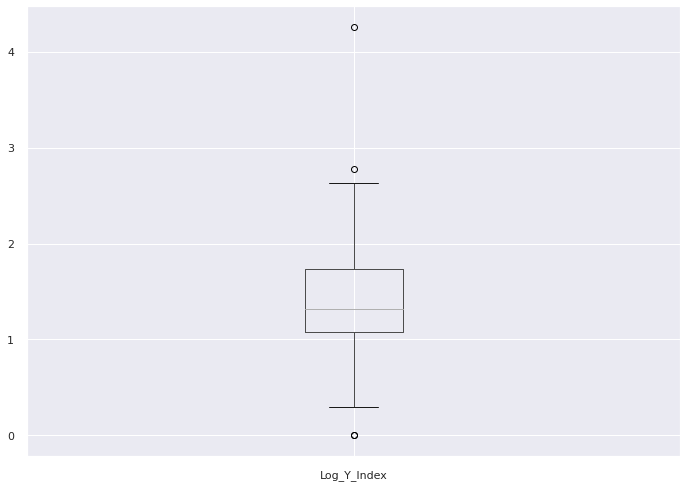

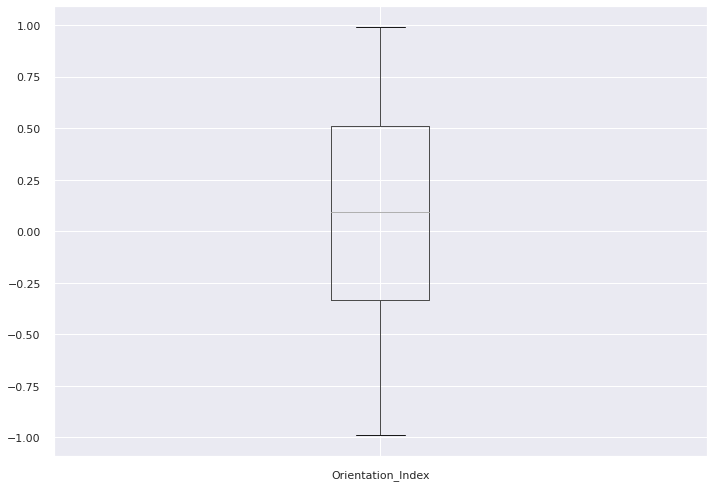

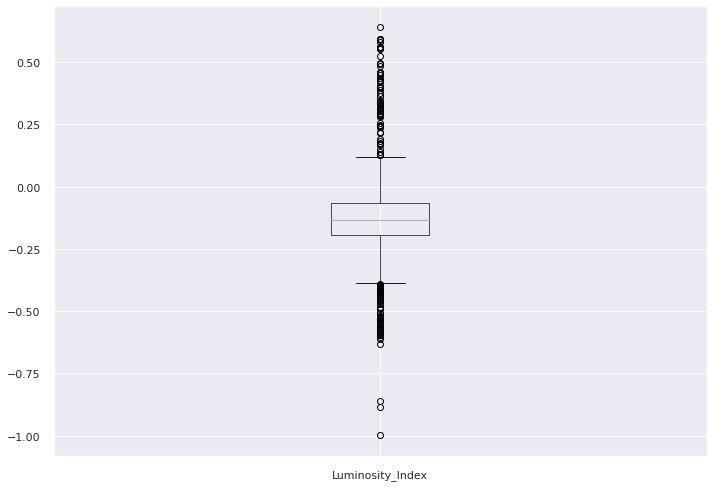

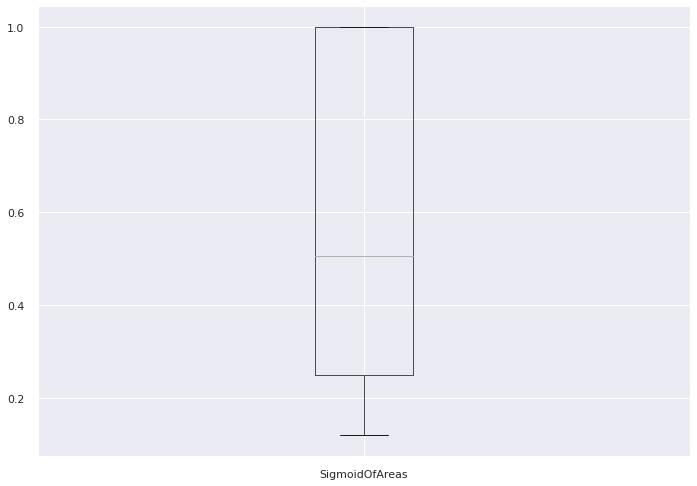

In [ ]:
for column in feutures:
    plt.figure()
    df.boxplot([column]) # a lot of outliers

df = df[(np.abs(stats.zscore(feutures)) < 4).all(axis=1)] # remove outliers in each column

In [ ]:
faults = df.iloc[:,-7:]
feutures = df.iloc[:,:-7]

x_train, x_test, y_train, y_test = train_test_split(feutures, faults, test_size=0.3, random_state=23)

faults_raw = df_raw.iloc[:,-7:]
feutures_raw = df_raw.iloc[:,:-7]

x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(feutures_raw, faults_raw, test_size=0.3, random_state=23)

## Modeling

In [ ]:
def FaultPlatesClassifier(x, y, est, analysis, params):
  """ A model to classify faulty steel plates. Input: x - a train test, y - labels of a train test, est - classifier 
  (rfc - random forest, xgb - Gradient Boosting), analysis - feature engineering technique to be used in the model 
  (pca - Principal Component Analysis, rfe - recursive feature elimination), params - a set of parameters to fine tune using Randomized Search;
  Output is the best model. """
  
  #data engineering
  dim = {'pca' : PCA(n_components = 0.99), 'rfe' : RFE(LogisticRegression(max_iter = 1000, multi_class = "multinomial"), step=1)}
    
  # dictionary with classifiers
  clf = {'rfc': RandomForestClassifier(), 'xgb': XGBClassifier()}
    
  # pipeline to apply to data. First scales features, then reduces number of features, finally applies classifier
  pipe = Pipeline([("scaler", MinMaxScaler()), ("feature", dim[analysis]), ("classifier", clf[est])])

  #trains a model, selects parameters using randomized search
  model = RandomizedSearchCV(estimator=pipe, param_distributions=params, cv=5, scoring="f1_weighted", refit=True, n_iter = 10)
  model.fit(x, y)
    
  #prints scores and model estimators
  print("best mean cross-validation score: {:.3f}".format(model.best_score_))
  print("best parameters:", model.best_params_) 
  
  return model

In [ ]:
# raw data
params = {"classifier__bootstrap" : [True, False], 
              'classifier__max_features' : ['auto', 'sqrt', 'log2'],
              'classifier__max_depth' :  list(range(1, 50)),
              'classifier__criterion' : ['gini', 'entropy'],
              'classifier__n_estimators' :  list(range(1, 300)),
              'classifier__class_weight' :[None, "balanced", "balanced_subsample"],
              'feature__n_features_to_select' : list(range(1, 27))}

model_rfc_rfe_raw = FaultPlatesClassifier(x_train_raw, np.array(y_train_raw).argmax(axis=1), "rfc", "rfe", params)

best mean cross-validation score: 0.782
best parameters: {'feature__n_features_to_select': 19, 'classifier__n_estimators': 131, 'classifier__max_features': 'log2', 'classifier__max_depth': 29, 'classifier__criterion': 'entropy', 'classifier__class_weight': None, 'classifier__bootstrap': False}


In [ ]:
# rfc with rfe
params = {"classifier__bootstrap" : [True, False], 
              'classifier__max_features' : [None, 'sqrt', 'log2'],
              'classifier__max_depth' :  list(range(1, 50)),
              'classifier__criterion' : ['gini', 'entropy'],
              'classifier__n_estimators' :  list(range(1, 300)),
              'classifier__class_weight' :[None, "balanced", "balanced_subsample"],
              'feature__n_features_to_select' : list(range(1, 27))}

model_rfc_rfe = FaultPlatesClassifier(x_train, np.array(y_train).argmax(axis=1), "rfc", "rfe", params)

best mean cross-validation score: 0.769
best parameters: {'feature__n_features_to_select': 18, 'classifier__n_estimators': 228, 'classifier__max_features': 'log2', 'classifier__max_depth': 14, 'classifier__criterion': 'entropy', 'classifier__class_weight': None, 'classifier__bootstrap': True}


In [ ]:
# rfc with pca
params = {"classifier__bootstrap" : [True, False], 
              'classifier__max_features' : [None, 'sqrt', 'log2'],
              'classifier__max_depth' :  list(range(1, 50)),
              'classifier__criterion' : ['gini', 'entropy'],
              'classifier__n_estimators' :  list(range(1, 300)),
              'feature__whiten' : [True, False],
              'feature__svd_solver' : ['auto', 'full']}

model_rfc_pca = FaultPlatesClassifier(x_train, np.array(y_train).argmax(axis=1), "rfc", "pca", params)

best mean cross-validation score: 0.724
best parameters: {'feature__whiten': True, 'feature__svd_solver': 'auto', 'classifier__n_estimators': 117, 'classifier__max_features': 'log2', 'classifier__max_depth': 43, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}


In [ ]:
# xgb with rfe
params = {'classifier__max_depth': [3, 18, 1],
                    'classifier__gamma': [1,9],
                    'classifier__reg_alpha':[40,180,1],
                    'classifier__reg_lambda': [0,1],
                    'classifier__colsample_bytree': [0.5,1],
                    'classifier__min_child_weight': [0,10,1],
                    'classifier__n_estimators': [180],
                    'feature__n_features_to_select' : list(range(1, 27))}

model_xgb_rfe = FaultPlatesClassifier(x_train, np.array(y_train).argmax(axis=1), "xgb", "rfe", params)

best mean cross-validation score: 0.700
best parameters: {'feature__n_features_to_select': 7, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 180, 'classifier__min_child_weight': 10, 'classifier__max_depth': 18, 'classifier__gamma': 1, 'classifier__colsample_bytree': 1}


In [ ]:
# xgb with pca
params = {'classifier__max_depth': [3, 18, 1],
                    'classifier__gamma': [1,9],
                    'classifier__reg_alpha':[40,180,1],
                    'classifier__reg_lambda': [0,1],
                    'classifier__colsample_bytree': [0.5,1],
                    'classifier__min_child_weight': [0,10,1],
                    'feature__whiten' : [True, False],
                    'feature__svd_solver' : ['auto', 'full']}

model_xgb_pca = FaultPlatesClassifier(x_train, np.array(y_train).argmax(axis=1), "xgb", "pca", params)

best mean cross-validation score: 0.539
best parameters: {'feature__whiten': True, 'feature__svd_solver': 'auto', 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 40, 'classifier__min_child_weight': 10, 'classifier__max_depth': 18, 'classifier__gamma': 1, 'classifier__colsample_bytree': 1}


## Results

In [ ]:
y_pred = model_rfc_rfe.predict(x_test)
y_test = np.array(y_test).argmax(axis=1)

rename = {0 : 'Pastry', 1 : 'Z_Scratch', 2 : 'K_Scatch', 3 : 'Stains', 4 : 'Dirtiness', 5 : 'Bumps', 6 : 'Other_Faults'}

y_pred2 = list(map(rename.get, y_pred))
y_test2 = list(map(rename.get, y_test))


In [ ]:
# Other_Faults are missclassified mainly; if excluded then accuracy is raised up to 82%
print(confusion_matrix(y_pred2, y_test2, labels = list(faults.columns)))
print(classification_report(y_test2, y_pred2))

[[ 29   0   0   0   0   8   4]
 [  1  46   0   0   0   0   2]
 [  0   3  90   0   0   0   1]
 [  0   0   1  23   0   1   1]
 [  0   0   0   0  13   0   1]
 [  4   0   2   1   0  88  27]
 [ 16   3   5   1   7  36 133]]
              precision    recall  f1-score   support

       Bumps       0.72      0.66      0.69       133
   Dirtiness       0.93      0.65      0.76        20
    K_Scatch       0.96      0.92      0.94        98
Other_Faults       0.66      0.79      0.72       169
      Pastry       0.71      0.58      0.64        50
      Stains       0.88      0.92      0.90        25
   Z_Scratch       0.94      0.88      0.91        52

    accuracy                           0.77       547
   macro avg       0.83      0.77      0.79       547
weighted avg       0.78      0.77      0.77       547



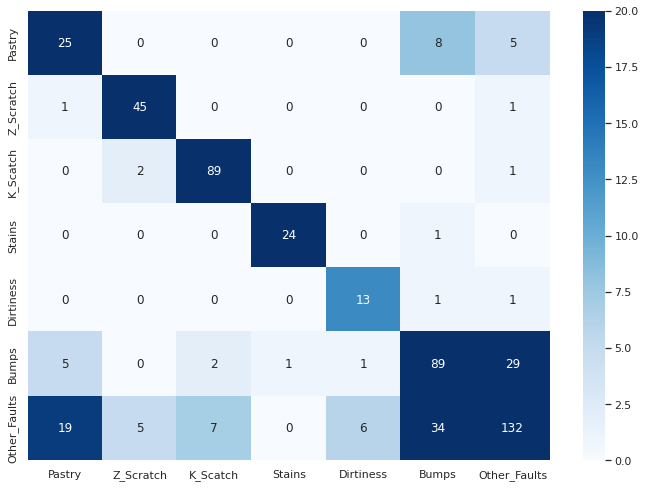

In [ ]:
#import seaborn as sns
sns.heatmap(confusion_matrix(y_pred2, y_test2, labels = faults.columns), annot = True, vmin = 0, vmax = 20, 
            xticklabels = faults.columns, yticklabels = faults.columns, cmap = "Blues", fmt='g')

## Clustering of the other type

In [ ]:
df_oth = df_raw[df_raw.Other_Faults == 1] #filter only other category
df_oth = df_oth.iloc[:, :-7] # remove labels

In [ ]:
def OtherClustering(x):
    """ Split dataset into clusters from 2 to 15. Input is a dataset. Output is a list of inertia, silhouette score and dictionary of all kmeans models""" 
    inertia = []
    silhouette = []
    kmeansmodel = {}
    
    for i in range(2, 15):
    
        # pipeline to apply to data. First scales features, then reduces number of features, finally applies classifier
        
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(x)
        
        kmeans = KMeans(n_init = 30, n_clusters = i, max_iter = 500)
        kmeans.fit(scaled_features)
        
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(scaled_features, kmeans.labels_))
        
        kmeansmodel[i] = kmeans
        
        visualizer = SilhouetteVisualizer(kmeans, colors='Paired')
        visualizer.fit(scaled_features)        # Fit the data to the visualizer
        visualizer.show()
        
    plt.plot(range(2, 15), silhouette)
    plt.xticks(range(2, 15))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
    
    plt.plot(range(2, 15), inertia)
    plt.xticks(range(2, 15))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
        
  
    return inertia, silhouette, kmeansmodel

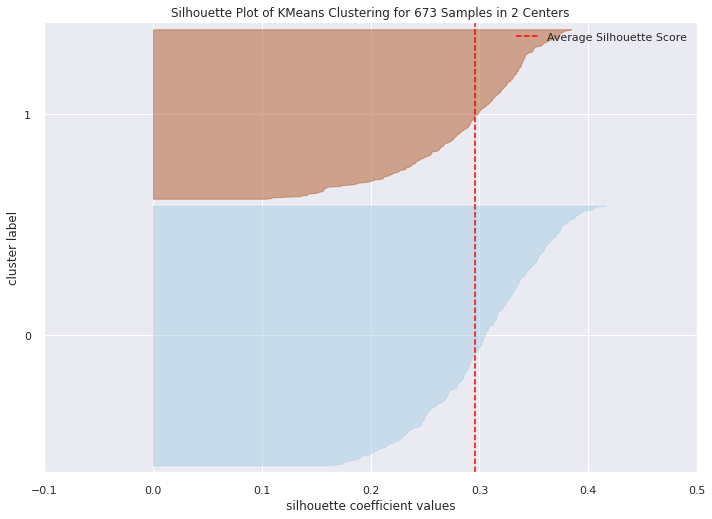

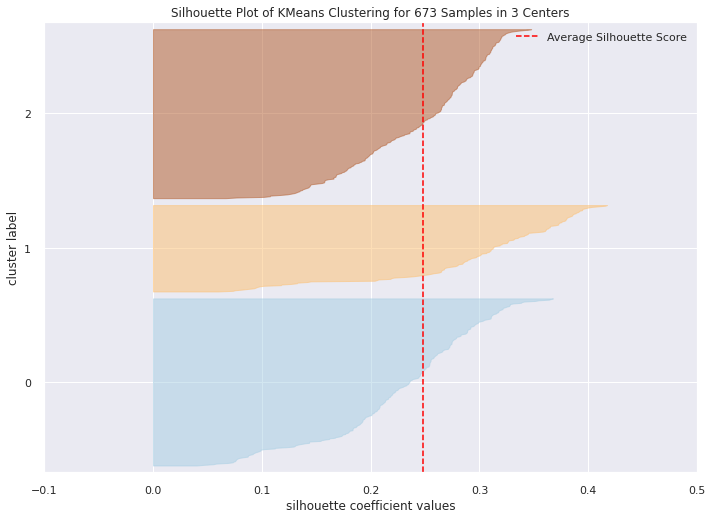

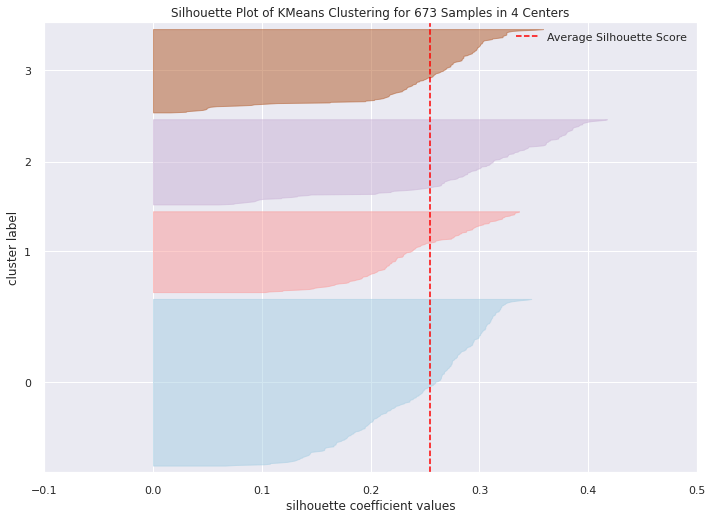

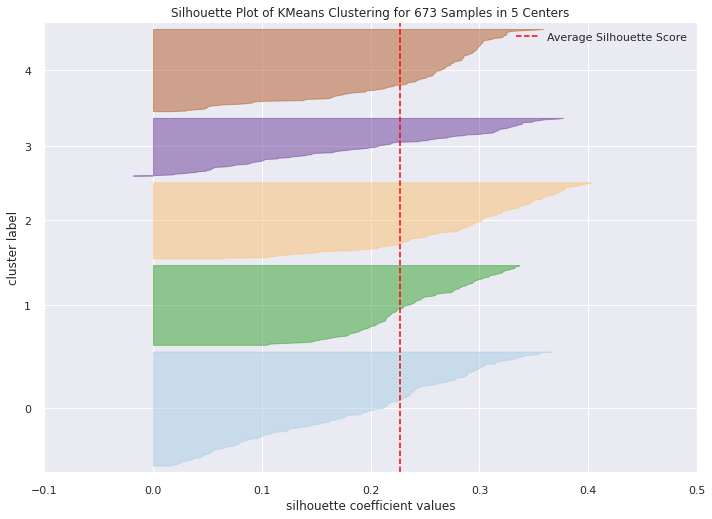

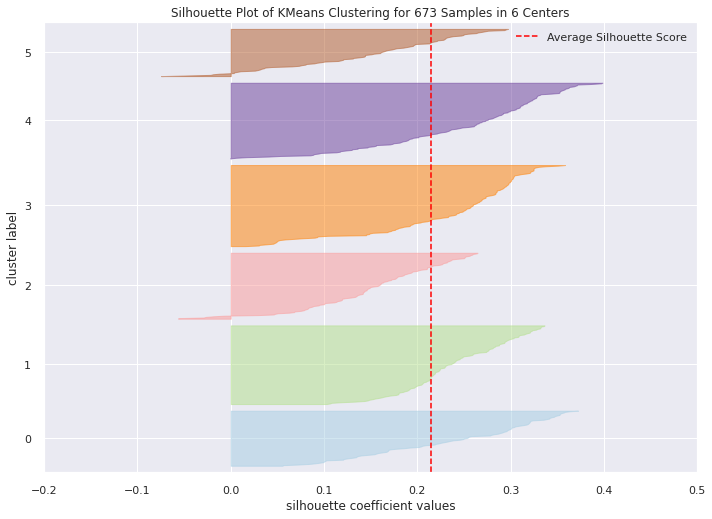

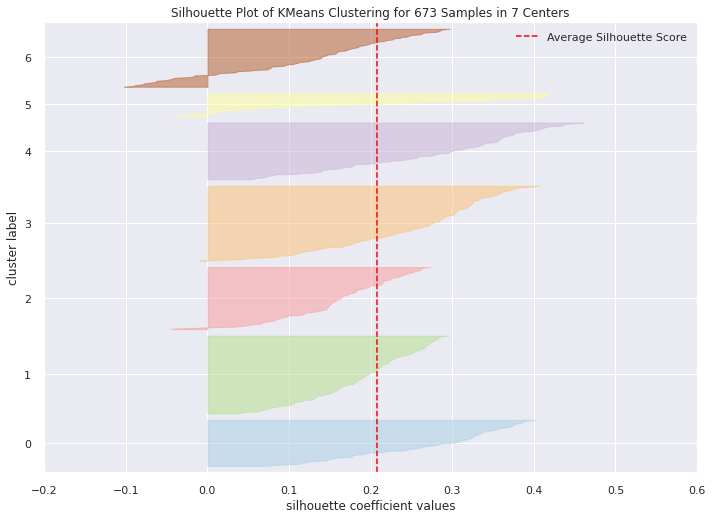

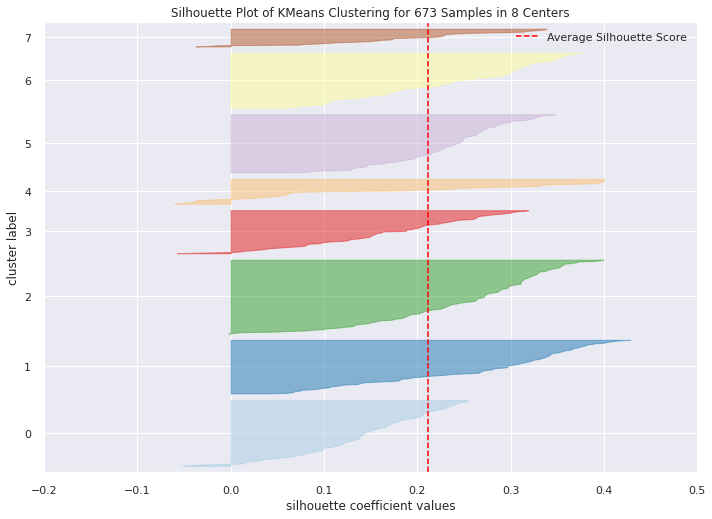

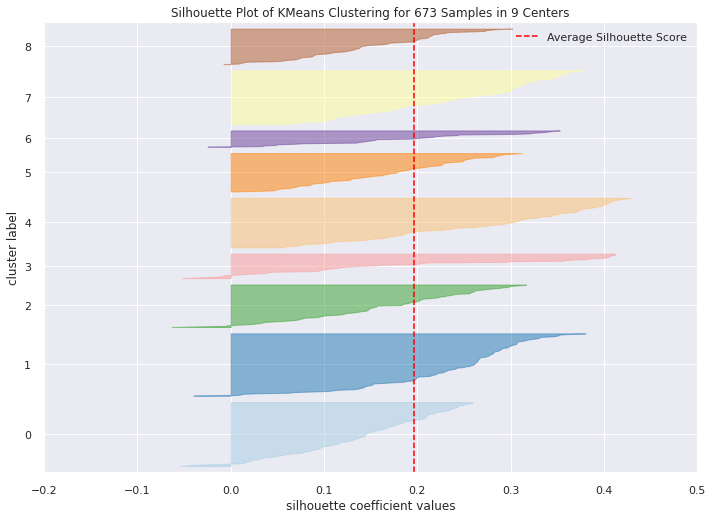

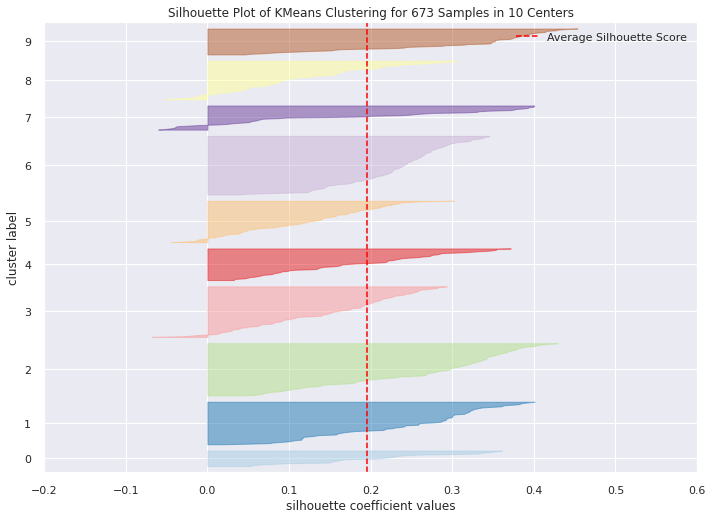

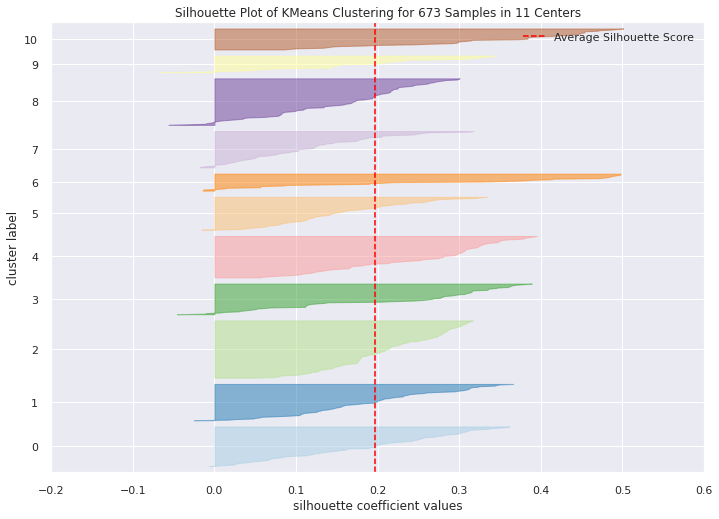

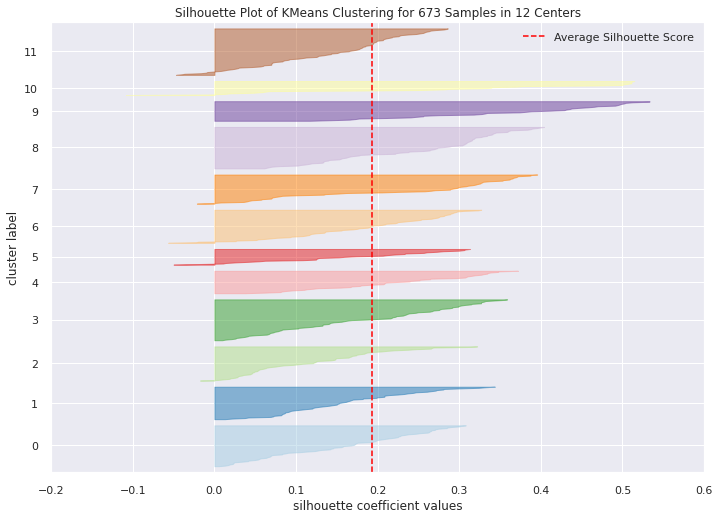

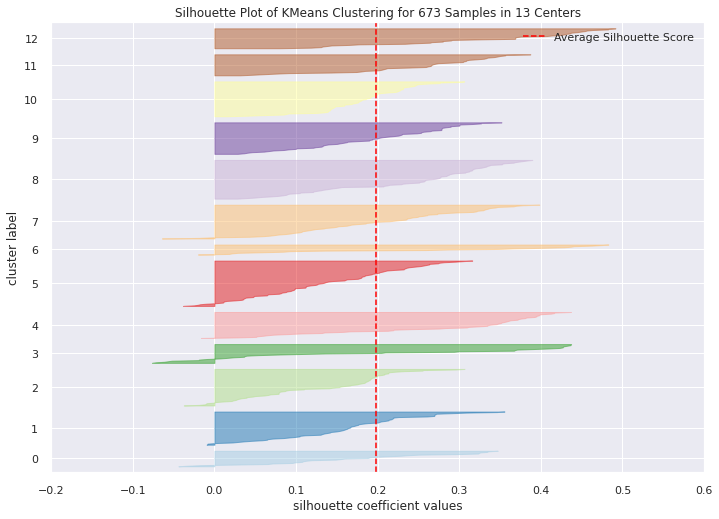

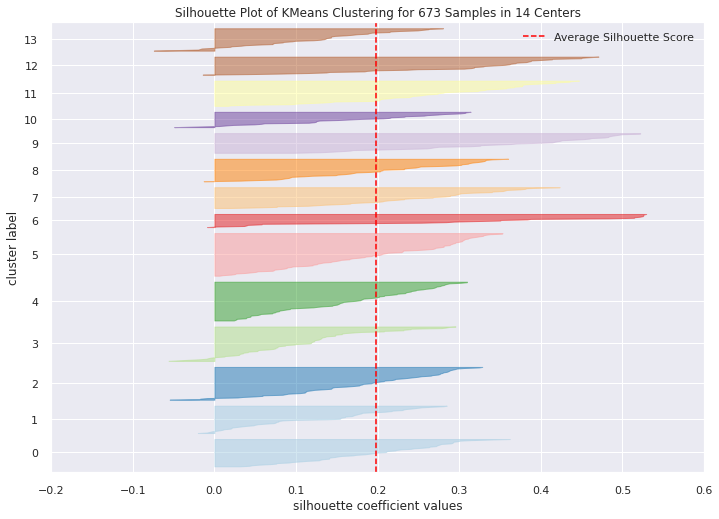

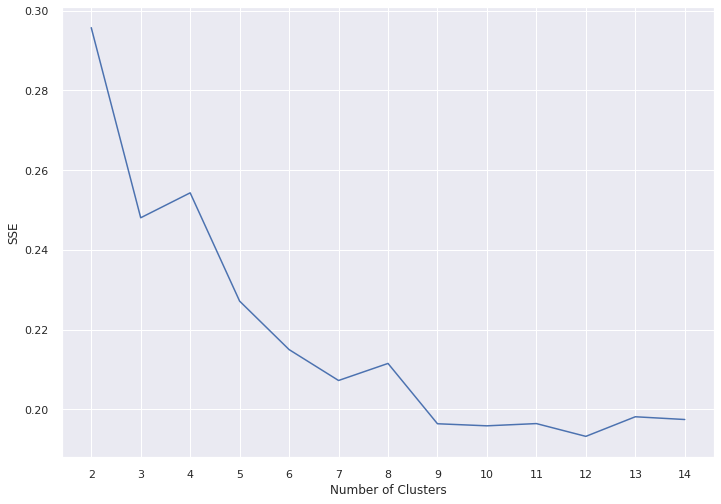

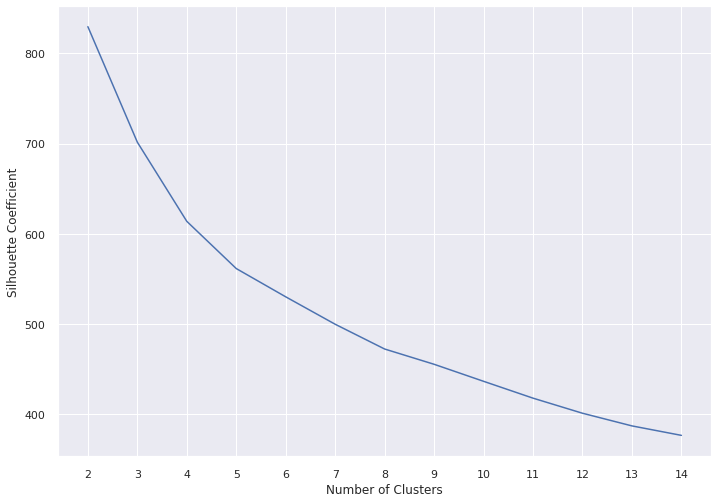

In [ ]:
inet, sil, kmeansModel = OtherClustering(df_oth)

In [ ]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_oth)

y_pred = kmeansModel[2].predict(scaled_features)

Text(0.5, 0, 'X Minimum')

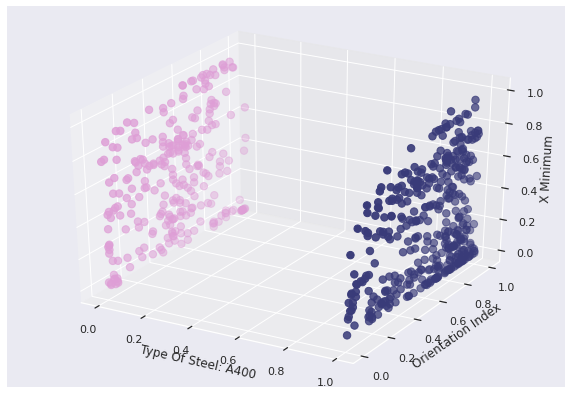

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(scaled_features[:, 12], scaled_features[:, 24], scaled_features[:, 0], c=y_pred, s=55, cmap='tab20b')
plt.xlabel("Type Of Steel: A400")
plt.ylabel("Orientation Index")
ax.set_zlabel('X Minimum')